## COMP 0137 Machine Vision: Homework 1
### Part II. practicalMixGauss_Apples

In [245]:
import os 
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as spio
import glob

from numpy import sqrt, pi, exp, transpose, matmul
from numpy.linalg import det, inv

%matplotlib inline

In [246]:
# Only unse this function if you encounter that the code doesn't run because there is some singular matrix (non-invertible)
'''
def inv(m):
    a, b = m.shape
    if a != b:
        raise ValueError("Only square matrices are invertible.")

    i = np.eye(a, a)
    return np.linalg.lstsq(m, i)[0]
'''

'\ndef inv(m):\n    a, b = m.shape\n    if a != b:\n        raise ValueError("Only square matrices are invertible.")\n\n    i = np.eye(a, a)\n    return np.linalg.lstsq(m, i)[0]\n'

#### A) Download and unzip the file apples.zip. Notice that for every color photo containing apples, there is a corresponding binary image mask. In a mask image, white pixels indicate locations where the corresponding photo is an apple. In floating point, you may need to threshold to get binary values. Note that these mask images are inexact! While a perfect ground-truth mask image’s black pixels should correspond to non-apples, these masks were painted in a hurry, so the white areas were painted conservatively.

In this section we load the training images and their respectives masks from the 'apples' folder.
- The image pixels have 3 values (RGB) and the mask pixels have 4 values (RGBA) -- R = red, B = blue, G = green, A = alpha.
- The alpha parameter is a number between 0 (fully transparent) and 1 (fully opaque). 
- Since we know the mask images are only in black and white, pixels in masks can only have two RGBA combinations:
- [0, 0, 0, 1] = black --> no apple
- [1, 1, 1, 1] = white --> apple

Knowing this, we can just take the first value of every pixel in the mask arrays and essentially turn them into greyscale arrays of dimensions pixels_y by pixels_x, and each pixel has only one value, either 0 or 1.

- 0 corresponds to color black --> no apple

- 1 corresponds to color white --> apple

In [247]:
# for files in os.listdir("./apples/apples"):
# print(files)

im1 = plt.imread('./apples/apples/Apples_by_kightp_Pat_Knight_flickr.jpg')
mk1 = plt.imread('./apples/apples/Apples_by_kightp_Pat_Knight_flickr.png')
im2 = plt.imread('./apples/apples/ApplesAndPears_by_srqpix_ClydeRobinson.jpg')
mk2 = plt.imread('./apples/apples/ApplesAndPears_by_srqpix_ClydeRobinson.png')
im3 = plt.imread('./apples/apples/bobbing-for-apples.jpg')
mk3 = plt.imread('./apples/apples/bobbing-for-apples.png')

mk1 = mk1[:,:,0]
mk2 = mk2[:,:,0]
mk3 = mk3[:,:,0]

# Now note that the elements in the mask functions are floats. Let's make them integers.
mk1 = mk1.astype(int)
mk2 = mk2.astype(int)
mk3 = mk3.astype(int)

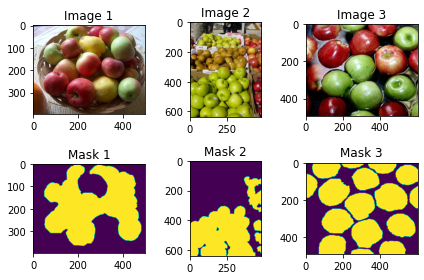

In [248]:
# Plot the images and their masks just for the sake of visualisation.

f, ax = plt.subplots(2, 3)
ax[0,0].imshow(im1)
ax[0,0].set_title('Image 1')
ax[1,0].imshow(mk1)
ax[1,0].set_title('Mask 1')
ax[0,1].imshow(im2)
ax[0,1].set_title('Image 2')
ax[1,1].imshow(mk2)
ax[1,1].set_title('Mask 2')
ax[0,2].imshow(im3)
ax[0,2].set_title('Image 3')
ax[1,2].imshow(mk3)
ax[1,2].set_title('Mask 3')
plt.tight_layout()

Here we can see a plot of the different images with their respective masks. The yellow color corresponds to a value of 1 (apple), and the purple color corresponds to a value of 0 (no apple).

In the following part, we simply manipulate the image arrays so that we can use them in our functions designed for fitting a mixtuire of gaussians. We concatenate the pixels of every image so that we end up with arrays of 3xn, where n is the total number of pixels in that image, and the 3 comes from the RGB values of each pixel. Then we concatenate all the pixels of the different images together so that we end up with one big array containing all the pixels for training.

Finally, we use the mask functions to extract which pixels correspond to "Apples" and which ones correspond to "Non-Apples", and we create two arrays with the pixels of each class.

In [249]:
# Make the image arrays 3xn and mask arrays 1xn.
im1 = np.reshape(im1, (im1.shape[0]*im1.shape[1],im1.shape[2])).T
im2 = np.reshape(im2, (im2.shape[0]*im2.shape[1],im2.shape[2])).T
im3 = np.reshape(im3, (im3.shape[0]*im3.shape[1],im3.shape[2])).T

mk1 = np.reshape(mk1, (mk1.shape[0]*mk1.shape[1],))
mk2 = np.reshape(mk2, (mk2.shape[0]*mk2.shape[1],))
mk3 = np.reshape(mk3, (mk3.shape[0]*mk3.shape[1],))

# Make a general IMAGE array and a general MASK array concatenating the arrays.
IM = np.concatenate((im1, im2, im3), axis=1)
MK = np.concatenate((mk1, mk2, mk3))

# Choose which pixels are apples or non-apples comparing from the masks, and create RGBApples and RGBNonApples.
RGBApples = IM[:, MK==1]
RGBNonApples = IM[:, MK==0]

#### B) Use mixtures of Gaussians to distinguish apple vs. non-apple pixels. Use red, green, and blue as your dimensions for now. Make any other decisions you need to, and document them in your .ipynb notebook.

Looking at the images we have, I can see that the apples can either be red or green. Therefore, the apples RGB values will be around the red RGB combination and the green RGB combination. This way we can assume that the data (RGB values for apples) can be fitted with a mix of two gaussian distributions. k = 2.

For the non-apples RGB values, we will also assume that the pixels can be fitted by a mixture of two gaussians as well, for convenience. k = 2.

For this part we will use the functions defined in 'practicalMixGaussC'. I have copy pasted the relevant fucntions to this notebook and adjusted them for the current problem.

In [250]:
#the goal of this routine is to evaluate a Gaussian likelihood
def getGaussProb(data,gaussMean,gaussCov):
    """
    Returns the likelihood that each data point in data belongs to the Gaussian described by gaussMean and 
    gaussCov.
    
    Keyword arguments:
    data -- d by 1 matrix of one data point. d is the number of dimensions of that data point
    gaussMean -- d by 1 vector containing the mean parameter of the Gaussian distribution.
    gaussCov -- d by d matrix containing the covariance parameters of the Gaussian distribution.
    
    Returns: 
    like -- 1 by n vector contianing the likelihood that each data point in data belongs to the Gaussian 
    distribution defined by gaussMean and gaussCov.
    """
    nDim = data.shape[0]
    
    #TO DO (b) - fill in this routine, replace the placeholders for like with the actual equation.
    
    like = 1/((2*pi)**(nDim/2)) * det(gaussCov)**(-1/2) * exp(-0.5 * (np.expand_dims(data-gaussMean,1).T @ inv(gaussCov) @ (np.expand_dims(data-gaussMean,1))))

    return like.item()

In [251]:
def getMixGaussLike(data, mixGaussEst): 
    """
    Calculate the log likelihood for the whole dataset under a mixture of Gaussians model.
    
    Keyword arguments:
    data -- d by n matrix containing data points.
    mixGaussEst -- dict containing the mixture of gaussians parameters.

    Returns: 
    logLike -- scalar containing the log likelihood.
    
    """
    
    data = np.atleast_2d(data)                                                                         
    # find total number of data items                                                                  
    nDims, nData = data.shape                                                                          
    
    # initialize log likelihoods                                                                       
    Like = 0;                                                                                       
                                                                                                       
    # run through each data item                                                                       
    for cData in range(nData):                                                                         
        thisData = data[:, cData]                                                                      
        # TO DO (i)- calculate likelihood of this data point under mixture of                         
        # Gaussians model. Replace this                                                                
        like = 0
        
        for k in range(mixGaussEst['k']):
            lam = mixGaussEst['weight'][k]
            mu = mixGaussEst['mean'][:,k]
            covar = mixGaussEst['cov'][:,:,k]
            like += lam * getGaussProb(thisData, mu, covar)
        
        # add to total like                                                                        
        Like = Like + like                                                              
                                                                                                       
    return  Like.item() # np.asscalar(logLike) -- this modification was suggested when I ran the code    

In [252]:
# This function will be useful. Turns vectors of dimension (d,) into (d,1)
def col(x):
    return np.expand_dims(x,1)

In [253]:
def fitMixGauss(data, k):
    """
    Estimate a k MoG model that would fit the data. Incremently plots the outcome.
               
    
    Keyword arguments:
    data -- d by n matrix containing data points.
    k -- scalar representing the number of gaussians to use in the MoG model.
    
    Returns: 
    mixGaussEst -- dict containing the estimated MoG parameters.
    
    """
    
    #     MAIN E-M ROUTINE  
    #     In the E-M algorithm, we calculate a complete posterior distribution over                                  
    #     the (nData) hidden variables in the E-Step.  
    #     In the M-Step, we update the parameters of the Gaussians (mean, cov, w).   
    
    nDims, nData = data.shape

    eps = 1e-10

    postHidden = np.zeros(shape=(k, nData)) # responsibilities

    # we will initialize the values to random values
    mixGaussEst = dict()
    mixGaussEst['k'] = k
    mixGaussEst['d'] = nDims
    mixGaussEst['weight'] = (1 / k) * np.ones(shape=(k))
    mixGaussEst['mean'] = 2 * np.random.randn(nDims, k)
    mixGaussEst['cov'] = np.zeros(shape=(nDims, nDims, k))
    for cGauss in range(k):
        mixGaussEst['cov'][:, :, cGauss] = 2.5 + 1.5 * np.random.uniform() * np.eye(nDims)
        
    
    # calculate current likelihood
    # TO DO (j) starts here - fill in this routine

    nIter = 20

    for cIter in range(nIter):

        # ===================== =====================
        # Expectation step
        # ===================== =====================
        
        curCov = mixGaussEst['cov']                                                                                  
        curWeight = mixGaussEst['weight']                                                                            
        curMean = mixGaussEst['mean'] 

        for cData in range(nData):
            # TO DO : fill in column of 'hidden' - calculate posterior probability that
            # this data point came from each of the Gaussians
            # replace this:
            thisData = data[:, cData]
            
            for cGauss in range(k):
                postHidden[cGauss, cData] = curWeight[cGauss] * getGaussProb(thisData, curMean[:,cGauss], curCov[:,:,cGauss])                                                                                        
            
            postHidden[:, cData] = postHidden[:, cData] / (np.sum(postHidden[:, cData]) + eps)
            
            

        # ===================== =====================
        # Maximization Step
        # ===================== =====================
        # for each constituent Gaussian
        for cGauss in range(k):
            # TO DO :  Update weighting parameters mixGauss.weight based on the total
            # posterior probability associated with each Gaussian. Replace this:

            mc = np.sum(postHidden[cGauss,:]) 

            mixGaussEst['weight'][cGauss] = mc / nData
            
            
            # TO DO :  Update mean parameters mixGauss.mean by weighted average
            # where weights are given by posterior probability associated with
            # Gaussian.  Replace this:
            mixGaussEst['mean'][:,cGauss] = (1/mc) * np.sum(postHidden[cGauss,:] * data, 1)
            
            
            # TO DO :  Update covarance parameter based on weighted average of
            # square distance from update mean, where weights are given by
            # posterior probability associated with Gaussian
            sum_C = 0
            
            for cData in range(nData):
                C = postHidden[cGauss,cData] * col(data[:,cData] - mixGaussEst['mean'][:,cGauss]) @ (col(data[:,cData] - mixGaussEst['mean'][:,cGauss]).T)
                sum_C = sum_C + C

            mixGaussEst['cov'][:,:,cGauss] = (1/mc) * sum_C

    return mixGaussEst

Note that we have added the eps = 1e-10 value in the calculation of the responsibilities to avoid dividing by zero, since at the start of the E-M process some data might be super unlikely given our initial conditions, and so the likelihood value will be very close to zero, leading the machine to believe we are dividing by zero and returning nan, which then doesn't let the code converge and find a proper solution.

Define the number of Gaussians we want to use to estimate each set of data (apples and non-apples), and find the parameters using the E-M algorithm. Each mixtiure of gaussians with its respective parameters is stored in a dictionary.

In [261]:
# Define number of components to estimate apple data
nGaussApple = 2

# Fit mixture of gaussians
mixGaussApple = fitMixGauss(RGBApples, nGaussApple)

In [262]:
# Do the same for non-apple data
nGaussNonApple = 2
mixGaussNonApple = fitMixGauss(RGBNonApples, nGaussNonApple)

In [263]:
# Show the values of the Mixture of Gaussians:
print('mixGaussApple =', mixGaussApple)
print('\n')
print('mixGaussNonApple =', mixGaussNonApple)

mixGaussApple = {'k': 2, 'd': 3, 'weight': array([0.45692734, 0.5381509 ]), 'mean': array([[153.60895924, 134.91702194],
       [176.62106498,  63.92943386],
       [ 58.38526043,  47.96618589]]), 'cov': array([[[1524.03247687, 3219.36258764],
        [1335.61037673, 2102.98911139],
        [1335.95199667, 2288.75838654]],

       [[1335.61037673, 2102.98911139],
        [1332.82344997, 3149.54056941],
        [1589.40047131, 2575.75520262]],

       [[1335.95199667, 2288.75838654],
        [1589.40047131, 2575.75520262],
        [3761.41860655, 2703.476356  ]]])}


mixGaussNonApple = {'k': 2, 'd': 3, 'weight': array([0.92407552, 0.06514104]), 'mean': array([[122.91282067,   1.46296604],
       [105.49485867,   1.10168296],
       [ 72.77127871,   2.02319075]]), 'cov': array([[[ 4.52171263e+03,  3.65941461e+00],
        [ 4.45306257e+03, -5.85854497e-01],
        [ 3.79134426e+03, -5.98446810e-01]],

       [[ 4.45306257e+03, -5.85854497e-01],
        [ 5.03876530e+03,  1.31121955e+00]

This is the part of the code that takes longest since we have a lot of data point to loop over (over 800,000).

- The code does not always converge the same way. In other words, the gaussians it finds to fit the data do not always have the same (or similar) parameters.
 
- I have run the code with different values of nGaussApple and nGaussNonApple, to see how different mixtures of gaussians fit the data. The results show that the assumption use of two gaussians for esimating each set of data was appropriate, because when I used 3 or 4 gaussians, the weights of 1 or 2 of them, respectively, were very close to zero, meaning that these extra gaussians were not used for estimating the data, and only 2 of them were relevant.

- The mean values of the gaussians in the mixGaussApple correspond to a shade of red and a shade of greed, which should be expected considering most of the apples were either red or green.

Next, we calculate the priors for Apples and NonApples, using the mask functions and the total number of pixels available (i.e. what proportion of the total pixels correspond to 'apples', and what proportion correspond to 'non-apple').

In [264]:
# Define the priors for Apple and Non-Apple
priorApple = len(MK[MK==1]) / len(MK)
priorNonApple = len(MK[MK==0]) / len(MK)

#### C) Download the file testApples.zip. Generate figures for your notebook, showing each pixel’s posterior probability of being “apple.” Comment on the outcomes.

Again, import the test image and manipulate it so that you can use it as an input for our defined functions.

In [265]:
# Load the images from test apples.
test1 = plt.imread('./testApples/Apples_by_MSR_MikeRyan_flickr.jpg')
test2 = plt.imread('./testApples/audioworm-QKUJj2wmxuI-original.jpg')
test3 = plt.imread('./testApples/Bbr98ad4z0A-ctgXo3gdwu8-original.jpg')

# Put the test images data in a list so that we can loop over them and automatically calculate the 
# posteriors and generate the plots all at once.
tests = []
tests.append(test1)
tests.append(test2)
tests.append(test3)

Using our mixture of gaussians distributions for 'Apples' and 'Non-Apples', we can calculate the likelihood of each pixel in the test images of corresponding to 'apple' or 'non-apple', and then use those values alongside the priors to calculate the posteriors of 'apple' with Baye's Theorem.

What we end up is, for every test image, an array of the same size of that image where every pixel has a probabiluty value between 0 and 1 representing the likelihood of that pixel corresponding to an 'apple'.

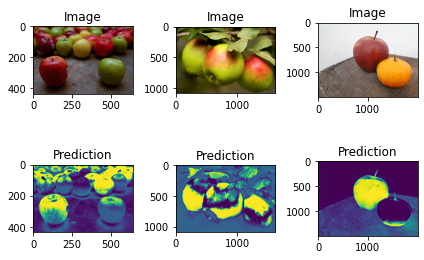

In [266]:
T = len(tests)

# Initialise a list where you will be storing the posteriors for each test image
posteriors = []

# Create figure to display the results
f, ax = plt.subplots(2, T)

for t in range(T):
    # now run through the pixels in the image and classify them as being apple or non apple - we will fill in the posterior
    imY, imX, imZ = tests[t].shape
    posteriorApple = np.zeros([imY,imX])

    for cY in range(imY): 
        for cX in range(imX):
            #extract this pixel's data
            thisPixelData = np.double(tests[t][cY,cX,:]) # get double precision
            thisPixelData = thisPixelData[:, np.newaxis] # --> make it a column vector
        
            #calculate likelihood of this data given Apple model
            likeApple = getMixGaussLike(thisPixelData, mixGaussApple)
            #calculate likelihood of this data given Non-Apple model
            likeNonApple = getMixGaussLike(thisPixelData, mixGaussNonApple)
        
            #calculate posterior probability from likelihoods and priors using BAYES rule.
            posteriorApple[cY,cX] = (likeApple * priorApple)/((likeApple * priorApple) + (likeNonApple * priorNonApple))
    
    posteriors.append(posteriorApple)
    
    ax[0,t].imshow(tests[t])
    ax[0,t].set_title('Image')
    ax[1,t].imshow(posteriorApple)
    ax[1,t].set_title('Prediction')

plt.tight_layout()

To better visualise the results we can apply a threshold to our posteriors. Every pixel with a probability higher than the threshold is classified as 'apple' (and given a value of 1), and the pixels with probability lower than our threshold are classifies as 'non-apple' (and given a value of 0). We use a threshold of 0.5.

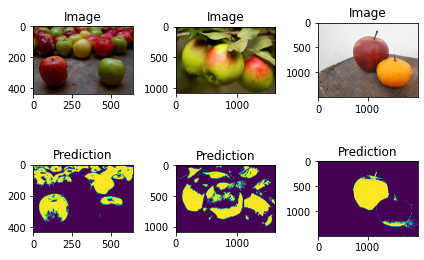

In [267]:
f, ax = plt.subplots(2, T)
for t in range(T):
    ax[0,t].imshow(tests[t])
    ax[0,t].set_title('Image')
    ax[1,t].imshow(np.where(posteriors[t] > 0.5, 1, 0))
    ax[1,t].set_title('Prediction')
plt.tight_layout()

Now the results are easier to interpret since we only have two colors in the output pictures: yellow representing the predicted apples, and purple representing the predicted non-apples. From this we can note a few things:
- Our algorithm does a good job at fitting the data, since we can differentiate the shape of the apples from the background in all of the pictures.
- Some pixels with vivid colors are mistaken for apples, such as the leaves, or other pieces of fruit such as the orange in teh third image.
- Some parts of the apples that have a different shade of red or green, or are darkened by a shadow, are incorrectly classified as 'non-apple'. This might also be a problem of the mixture of gaussians model not using enough clusters to fit the data.

Ways to improve:
- Increase the number of training data.
- Use validating set (more information about this in the last section of this coursework).
- The algorithm analyses each pixel independently. A better way to predict would be to take into account correlations between pixels (i.e. if one pixel corresponds to 'apple', the pixels nearby are most likely going to correspond to 'apple' as well). This way we would not predict incorrectly where the apple changes slightly its color, or part of it has a darker shade due to a shadow.

#### D) For the test image with a ground-truth mask, quantify and report your result.

In [268]:
# Create a function that will calculate the ROC curve for a given image
def ROCCurve (nThresh, groundTruth, posterior):
    '''
    Inputs:
    --> nThresh = number of thresholds you want to define, i.e. number of points in the ROC curve.
    --> groundTruth = ground truth array of the image where 1 = apple, 0 = non-apple pixels.
    --> posterior = array of posterior probabilities (ranging from 0 to 1) for each pixel in the test image.

    Outputs:
    --> ROC = array where you will store the True Positive Rate (TPR) and False Positive Rate (FPR)
            values for each threshold, to then plot the results.
            The 1st row of the ROC array will contain the FPR (x-axis of the plot).
            The 2nd row of the ROC array will contain the TPR (y-axis of the plot).
    '''

    # Define thresholds you are going to iterate over to create your ROC curve:
    thresh = np.linspace(0,1,nThresh)

    # Initialise ROC array
    ROC = np.zeros([2,len(thresh)])

    # Now loop over the thresholds to calculate the True Positives (TP), False Negatives (FN),
    # False Positives (FP), and True Negatives (TN), in order to caluclate the TPR and the FPR.
    for cThresh in range(nThresh):
        posteriorThresh = np.where(posterior > thresh[cThresh], 1, 0)
        
        TP = np.count_nonzero((posteriorThresh[posteriorThresh == 1] == groundTruth[posteriorThresh == 1]) == True)
        FN = np.count_nonzero((posteriorThresh[posteriorThresh == 0] != groundTruth[posteriorThresh == 0]) == True)
        FP = np.count_nonzero((posteriorThresh[posteriorThresh == 1] != groundTruth[posteriorThresh == 1]) == True)
        TN = np.count_nonzero((posteriorThresh[posteriorThresh == 0] == groundTruth[posteriorThresh == 0]) == True)
        
        TPR = TP / (TP + FN)
        FPR = FP / (FP + TN)

        ROC[0, cThresh] = FPR
        ROC[1, cThresh] = TPR

    return ROC

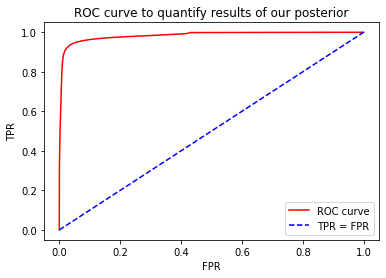

In [269]:
# Import the ground truth mask of the test image:
gt3 = plt.imread('./testApples/Bbr98ad4z0A-ctgXo3gdwu8-original.png')
gt3 = gt3[:,:,0]
gt3 = gt3.astype(int)

# Take the posteriors we calculated for this image from the preious section.
posteriorAppleTest = posteriors[-1]

# Create ROC curve from nThresh points
nThresh = 50

ROC = ROCCurve(nThresh, gt3, posteriorAppleTest)


# Plot the results
plt.plot(ROC[0,:], ROC[1,:], 'r', label='ROC curve')
plt.plot([0,np.max(ROC)], [0,np.max(ROC)], '--b', label='TPR = FPR')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.title('ROC curve to quantify results of our posterior')
plt.show()


Receives Operator Characteristic (ROC) curves are used to determine which threshold best classifies our data, without having to comput confusion matrices for each possible threshold in the dataset. The y-axis corresponds to the True Positive Rate (TPR), which in our problem tells us which proportion of apple pixels were correctly classified. The x-axis shows the False Positive Rate (FPR), which in our problem tells us the proportion of non-apple pixels that were incorrectly classified (i.e. that were classified as apples by our predictor).

The blue diagonal line shows where TPR = FPR, i.e. the proportion of correctly classified apple pixels is the same as the proportion of incorrectly classified non-apple pixels. This would be the performance expected by a random classifier (chance).

If our ROC curve is above the blue dotted line, means that our proportion of true positives is greater than the proportion of false positives, and therefore, our classifier is performing better than a random classifier.

From the ROC curve we could also extract the optimal threshold, which would be the one that has the largest TPR and the smallest FPR. This value would correspond to the threshold that produces either of the two "pointier" vertices to the left of the curve, at TPR = 1, and TPR ~ 0.7, and we would choose one or the other depending on the amount of false positives we are willing to tolerate.

#### E) Download two non-copyrighted photos with apples. Make good ground-truth masks for them. Use these as extra test-images. Report your qualitative and quantitative results.

I have downloaded two new images containing apples, and created ground-truth masks for them using an app called "Procreate". 
I have stored these new images and their masks in a new folder called "myTestApples".

In [272]:
# Load the new images and their masks.
myim1 = plt.imread('./myTestApples/AppleTest1.jpeg')
myim2 = plt.imread('./myTestApples/AppleTest2.jpeg')
mymk1 = plt.imread('./myTestApples/AppleTest1.png')
mymk2 = plt.imread('./myTestApples/AppleTest2.png')

mymk1 = mymk1[:,:,0]
mymk1 = mymk1.astype(int)
mymk2 = mymk2[:,:,0]
mymk2 = mymk2.astype(int)

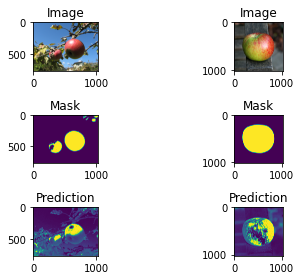

In [273]:
# Now we bascially do the same as when we tested the images, but for my new images.
myIms = []
myIms.append(myim1)
myIms.append(myim2)

myMks = []
myMks.append(mymk1)
myMks.append(mymk2)

I = len(myIms)

# Initialise a list where you will be storing the posteriors for each image
myImsPost = []

# Create figure to display the results
f, ax = plt.subplots(3, I)

for i in range(I):
    # now run through the pixels in the image and classify them as being apple or non apple - we will fill in the posterior
    imY, imX, imZ = myIms[i].shape
    posteriorApple = np.zeros([imY,imX])

    for cY in range(imY): 
        for cX in range(imX):
            #extract this pixel's data
            thisPixelData = np.double(myIms[i][cY,cX,:]) # get double precision
            thisPixelData = thisPixelData[:, np.newaxis] # --> make it a column vector
        
            #calculate likelihood of this data given Apple model
            likeApple = getMixGaussLike(thisPixelData, mixGaussApple)
            #calculate likelihood of this data given Non-Apple model
            likeNonApple = getMixGaussLike(thisPixelData, mixGaussNonApple)
        
            #calculate posterior probability from likelihoods and priors using BAYES rule.
            posteriorApple[cY,cX] = (likeApple * priorApple)/((likeApple * priorApple) + (likeNonApple * priorNonApple))
    
    myImsPost.append(posteriorApple)
    
    ax[0,i].imshow(myIms[i])
    ax[0,i].set_title('Image')
    ax[1,i].imshow(myMks[i])
    ax[1,i].set_title('Mask')
    ax[2,i].imshow(myImsPost[i])
    ax[2,i].set_title('Prediction')

plt.tight_layout()

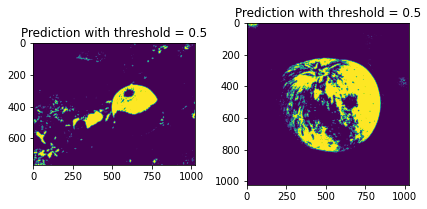

In [274]:
f, ax = plt.subplots(1, I)
for i in range(I):
    ax[i].imshow(np.where(myImsPost[i] > 0.5, 1, 0))
    ax[i].set_title('Prediction with threshold = 0.5')
plt.tight_layout()

In these new images we have the same issues we had identified before in our original test images:
- The overall shape of the apples is identified with respect to the background.
- Misclassifications in shaded areas of the apples (or areas with too much exposition).
- Misclassification of other objects with similar color shades as the apples, such as the leaves.
- Objects with color shades that significantly differ from the apple colors, such as the blue sky, the dark ground, or the brown tree branches, are correctly classified as non-apples.

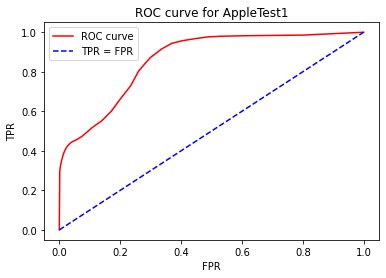

In [275]:
# Take the posteriors we calculated for AppleTest1.
posteriorAppleTest = myImsPost[0]

# Create ROC curve from nThresh points
nThresh = 50

ROC = ROCCurve(nThresh, myMks[0], posteriorAppleTest)


# Plot the results
plt.plot(ROC[0,:], ROC[1,:], 'r', label='ROC curve')
plt.plot([0,np.max(ROC)], [0,np.max(ROC)], '--b', label='TPR = FPR')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.title('ROC curve for AppleTest1')
plt.show()

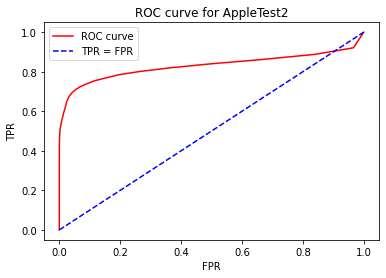

In [276]:
# Take the posteriors we calculated for AppleTest1.
posteriorAppleTest = myImsPost[1]

# Create ROC curve from nThresh points
nThresh = 50

ROC = ROCCurve(nThresh, myMks[1], posteriorAppleTest)


# Plot the results
plt.plot(ROC[0,:], ROC[1,:], 'r', label='ROC curve')
plt.plot([0,np.max(ROC)], [0,np.max(ROC)], '--b', label='TPR = FPR')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.title('ROC curve for AppleTest2')
plt.show()

The same comments as in the previous section can be made about the ROC curve for these new images. Note that in the ROC curve for AppleTest2, for very low thresholds we get higher rate of false positives than true positives, meaning that our classofoier would perform worse than a random classifier. This is corrected as thresholds increase.

Note that it was expected that the predictions for these new images would be qualitatively similar to the ones for the previous test images, since we have not used any validation set, we have not furhter tuned our parameters or made any changes to our predictive model.

#### F) We should really be using three separate sets of files: a training set, a validation set, and a test set! Explain why.
A validation set is different from a test set or a training set. If we train our model simply with a training set, then our model is prone to overfitting and as a result having a poor perfomance on the test set. Therefore, we can introduce a validation set, which we use after the training set to tune our model parameters. If we do not have much data, we can do cross-validation. Divide the training set in different sub-sets (say 5). Now we dedicate a large part of these sub-sets (say 4) to training the data, and the remaining (1) for validation. We do this for every possible combination of sub-sets (here 5 combinations - i.e. the first sub-set is used for validation and the rest for training, then the second sub-set is used for validation and the rest for training, and so on), and in the end, we average over the parameters obtained in each combination to obtain our final parameters.

The test set is simply used to test the performance of a trained model.

In this exercise, a validation set could have been used to further tune the parameters of our mixture of gaussians, fixing the misclassification issues with the different shades of reds and greens in the apples, and the other objects with similar bright colors as the apples, such as leaves, oranges or lemons. It could have also been used to find the trheshold that best classifies our predicted data.